# Stock Price Prediction and Investment Recommendations
---
## Summary

**Background:**

We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.

Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

**Data Description:**

You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

**Goal(s):**

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

**Success Metrics:**

Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

# Import Libraries

In [1]:
# Standards
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
import random

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Data Preprocessing

## Data Loading

- Load data from different sheets for each company.
- Combine data into a single dataframe with an additional column indicating the company.

In [2]:
# Load data from Excel file
file_name = r"data\2020Q1Q2Q3Q4-2021Q1.xlsx"
xlsx = pd.ExcelFile(file_name)

# Get company names from sheet names
company_names = xlsx.sheet_names

# Load data from each sheet and store in a list of dataframes
dfs = []
for company in company_names:
    df = pd.read_excel(xlsx, company, skipfooter=1)
    df['Company'] = company  # Add a column to identify the company
    dfs.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

## Data Splitting

- Split data into training (2020) and testing (2021 Q1) sets.

In [3]:
# Split the data into training and test sets
train = combined_df[combined_df['Date'].dt.year == 2020]
test = combined_df[combined_df['Date'].dt.year == 2021]

## Data Cleaning

- Handle missing values.
- Convert date columns to datetime format.
- Ensure data consistency (e.g., stock prices should be non-negative).

In [4]:
# Handle missing values (fill or drop)
# First, check the number of missing values for each column
missing_values = combined_df.isnull().sum()
print(missing_values)

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Company     0
dtype: int64


In [5]:
# Convert 'Date' column to datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Data consistency
# Replace any negative stock prices with NaN (not a number)
combined_df.loc[combined_df['Price'] < 0, 'Price'] = None
combined_df.loc[combined_df['Open'] < 0, 'Open'] = None
combined_df.loc[combined_df['High'] < 0, 'High'] = None
combined_df.loc[combined_df['Low'] < 0, 'Low'] = None

# Convert 'Vol.' column to a consistent format
def volume_conversion(vol):
    if 'M' in vol:
        return float(vol.replace('M', '')) * 1_000_000
    elif 'K' in vol:
        return float(vol.replace('K', '')) * 1_000
    elif vol == '-':
        return None  # Convert '-' to NaN
    else:
        return float(vol)

combined_df['Vol.'] = combined_df['Vol.'].astype(str).apply(volume_conversion)

# Convert 'Change %' to a float 
# (remove the '%' sign and divide by 100)
combined_df['Change %'] = combined_df['Change %'].astype(str).str.rstrip('%').astype('float') / 100.0


## Feature Engineering

- Calculate technical indicators like Moving Averages, RSI, MACD, etc.
- Calculate historical returns for various periods (daily, weekly, monthly).
- Create lag features to capture temporal dependencies.

### Moving Averages

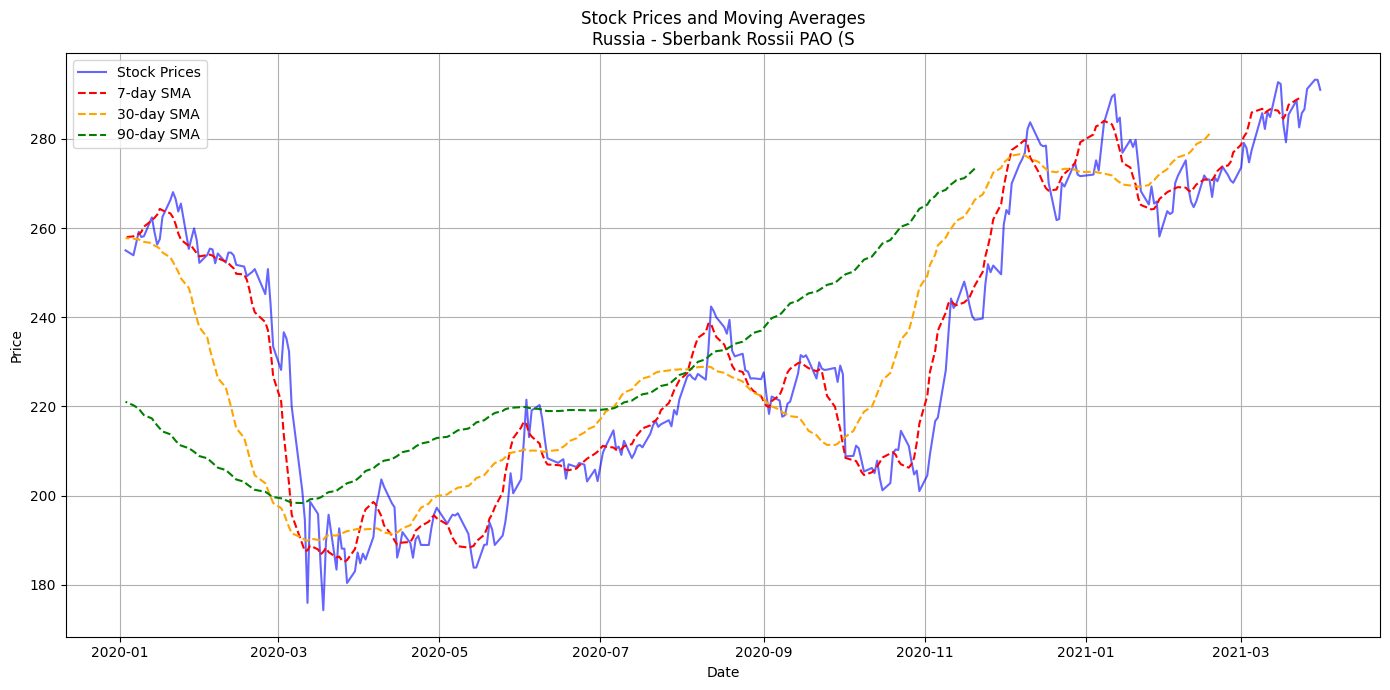

In [6]:
# Calculate the 7-day Simple Moving Average (SMA)
combined_df['7_SMA'] = combined_df['Price'].rolling(window=7).mean()

# Calculate the 30-day Simple Moving Average (SMA)
combined_df['30_SMA'] = combined_df['Price'].rolling(window=30).mean()

# Calculate the 90-day Simple Moving Average (SMA)
combined_df['90_SMA'] = combined_df['Price'].rolling(window=90).mean()

# Select a specific company for visualization (for visual clarity)
selected_company = company_names[0]
company_df = combined_df[combined_df['Company'] == selected_company]  # Replace 'YourCompanyName' with the desired company's name

plt.figure(figsize=(14, 7))

# Plotting the stock prices
plt.plot(company_df['Date'], company_df['Price'], label='Stock Prices', color='blue', alpha=0.6)

# Plotting the 7-day moving average
plt.plot(company_df['Date'], company_df['7_SMA'], label='7-day SMA', color='red', linestyle='--')

# Plotting the 30-day moving average
plt.plot(company_df['Date'], company_df['30_SMA'], label='30-day SMA', color='orange', linestyle='--')

# Plotting the 90-day moving average
plt.plot(company_df['Date'], company_df['90_SMA'], label='90-day SMA', color='green', linestyle='--')

plt.title('Stock Prices and Moving Averages'+'\n'+selected_company)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Relative Strength Index

Measures the speed and change of price movements. RSI oscillates between zero and 100 and is typically used to identify overbought or oversold conditions.

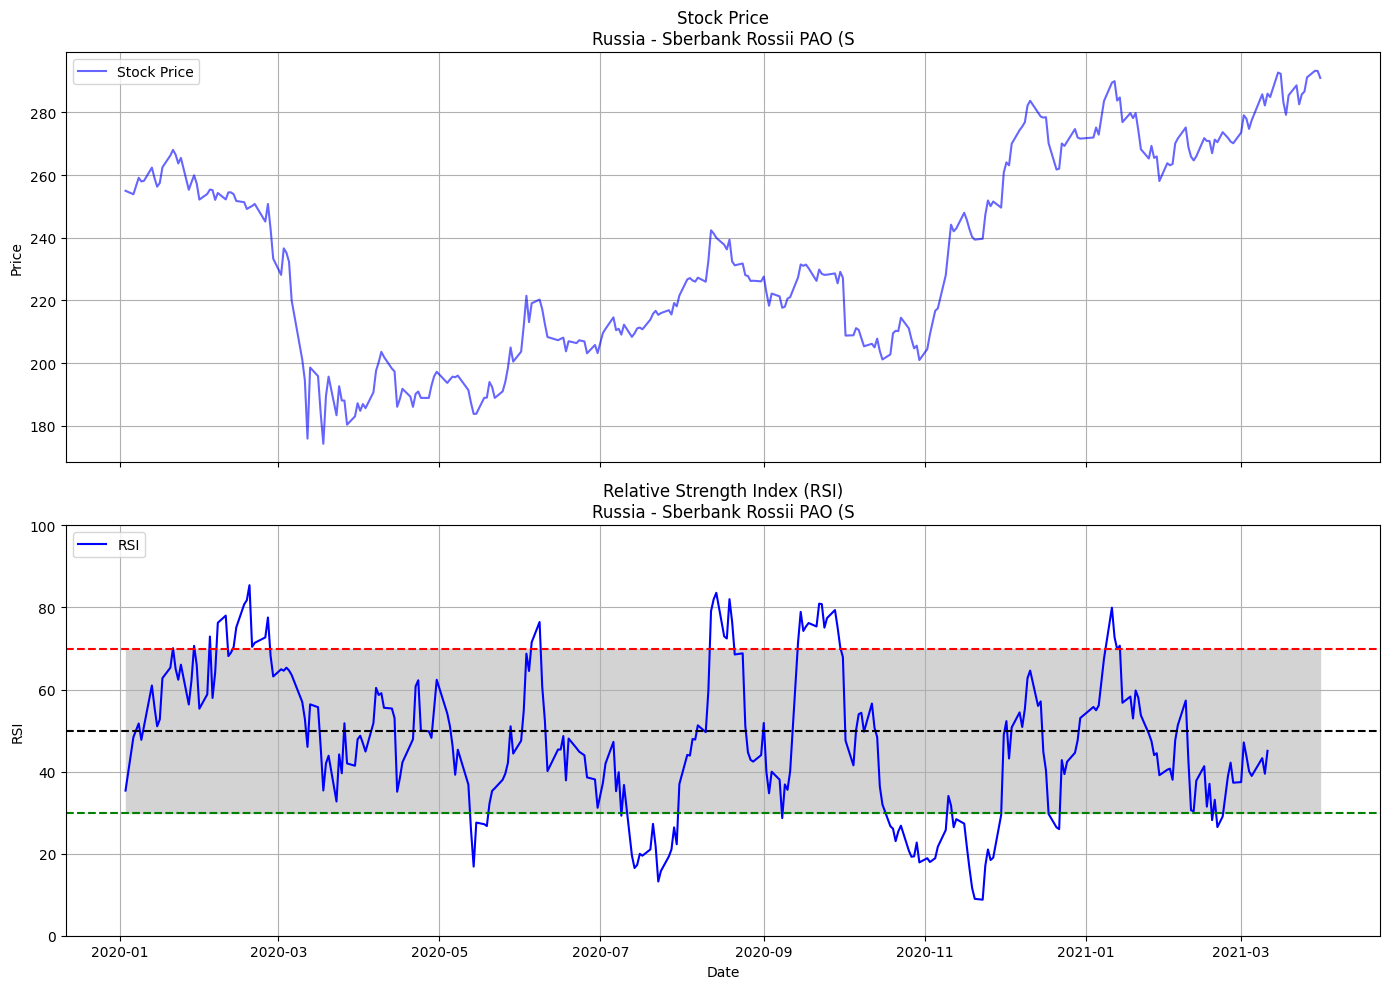

In [7]:
# Define RSI function for later
def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

combined_df['RSI'] = compute_rsi(combined_df['Price'], 14)

# Select a specific company for visualization (for clarity)
company_df = combined_df[combined_df['Company'] == selected_company]  # Replace 'YourCompanyName' with the desired company's name

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df['Date'], company_df['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the RSI on the second subplot
ax2.plot(company_df['Date'], company_df['RSI'], label='RSI', color='blue')

# Adding the overbought threshold
ax2.axhline(70, color='red', linestyle='--')

# Adding the oversold threshold
ax2.axhline(30, color='green', linestyle='--')

# Adding the neutral line
ax2.axhline(50, color='black', linestyle='--')

ax2.fill_between(company_df['Date'], y1=30, y2=70, color='lightgray')

ax2.set_title('Relative Strength Index (RSI)'+'\n'+selected_company)
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Moving Average Convergence Divergence

Momentum indicator that shows the relationship between two moving averages.

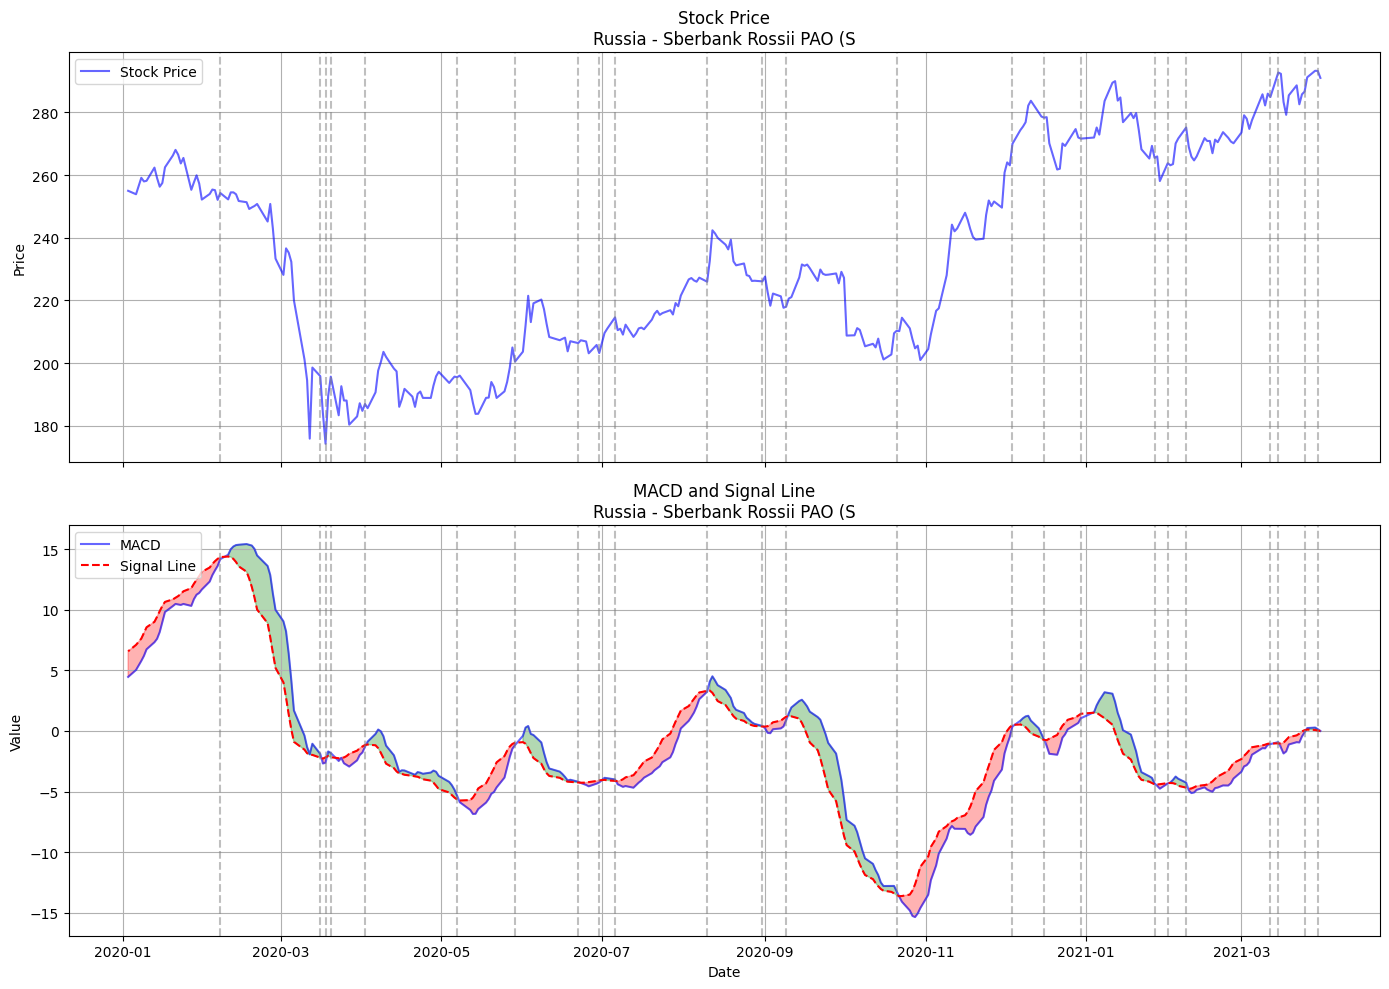

In [8]:
# Calculate the Short Term Exponential Moving Average
combined_df['14_EMA'] = combined_df['Price'].ewm(span=14, adjust=False).mean()

# Calculate the Long Term Exponential Moving Average
combined_df['30_EMA'] = combined_df['Price'].ewm(span=30, adjust=False).mean()

# Calculate MACD
combined_df['MACD'] = combined_df['14_EMA'] - combined_df['30_EMA']

# Calculate Signal Line
combined_df['Signal_Line'] = combined_df['MACD'].ewm(span=9, adjust=False).mean()

# Select a specific company for visualization (for clarity)
company_df = combined_df[combined_df['Company'] == selected_company]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df['Date'], company_df['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the MACD and Signal Line on the second subplot
ax2.plot(company_df['Date'], company_df['MACD'], label='MACD', color='blue', alpha=0.6)
ax2.plot(company_df['Date'], company_df['Signal_Line'], label='Signal Line', color='red', linestyle='--')

# Highlighting the area where MACD is above the signal line (potential buy zone)
ax2.fill_between(company_df['Date'], company_df['MACD'], company_df['Signal_Line'], where=(company_df['MACD'] > company_df['Signal_Line']), color='green', alpha=0.3)

# Highlighting the area where MACD is below the signal line (potential sell zone)
ax2.fill_between(company_df['Date'], company_df['MACD'], company_df['Signal_Line'], where=(company_df['MACD'] <= company_df['Signal_Line']), color='red', alpha=0.3)

# Identify intersection points
crossings = ((company_df['MACD'] > company_df['Signal_Line']) & (company_df['MACD'].shift(1) <= company_df['Signal_Line'].shift(1))) | ((company_df['MACD'] < company_df['Signal_Line']) & (company_df['MACD'].shift(1) >= company_df['Signal_Line'].shift(1)))

# Plot vertical lines on both subplots at the intersection points
# Visually indicates potential 'action' points of buy/sell
for date in company_df['Date'][crossings]:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.5)


ax2.set_title('MACD and Signal Line'+'\n'+selected_company)
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Exploratory Data Analysis

- Visualize stock price trends for different companies.
- Visualize distribution of returns.
- Correlation analysis between different technical indicators.

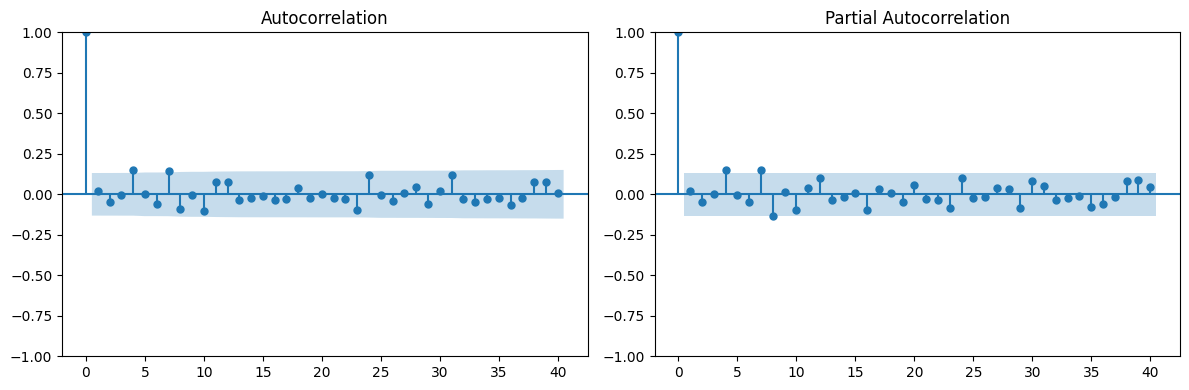

In [9]:
# Select a specific company for analysis
company_df = combined_df[combined_df['Company'] == selected_company].copy()

# First differencing to make the series stationary
company_df['Price_Diff'] = company_df['Price'].diff()

# Drop NaN values introduced by differencing
company_df.dropna(inplace=True)

# Plot ACF and PACF to help decide on p and q
# Visual aid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(company_df['Price_Diff'], lags=40, ax=ax1)
plot_pacf(company_df['Price_Diff'], lags=40, ax=ax2)
plt.tight_layout()
plt.show()

# ARIMA - Model Development

## Model Selection

- Consider models like ARIMA, Prophet, LSTM, and other time series forecasting models.
- Use cross-validation on the training set to tune hyperparameters.

In [ ]:
# Train and Test function, so that we can pass multiple companies or variable pdq values.
def train_test_arima_for_company(company_name, train, test, p, d, q):
    # Filter data for the given company and ensure it's sorted by date
    train_data = train[train['Company'] == company_name].sort_values(by='Date')
    test_data = test[test['Company'] == company_name].sort_values(by='Date')

    # Ensure the 'Date' column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Fit the ARIMA Model on the training data
    model = ARIMA(train_data['Price'], order=(p, d, q))
    results = model.fit()

    # Forecast the values for the test set duration
    forecast = results.forecast(steps=len(test_data))

    # Evaluate the model's performance
    mse = mean_squared_error(test_data['Price'], forecast)
    rmse = np.sqrt(mse)
    print(f"Company: {company_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot the actual vs. predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(train_data['Date'], train_data['Price'], label='Training Data', color='blue', alpha=0.6)
    plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data', color='green', alpha=0.6)
    plt.plot(test_data['Date'], forecast, label='ARIMA Forecast', color='red', linestyle='--')
    plt.title(f'ARIMA Model Forecast vs Actuals for {company_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# Optimization function to determine pdq
def arima_grid_search_for_company(company_name, train, p_values, d_values, q_values):
    # Filter training data for the given company
    train_data = train[train['Company'] == company_name]['Price']
    
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    results = model.fit()
                    # Check if the current model's AIC is lower than the previous best
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = order
                        best_model = results
                except:
                    continue

    return company_name, best_order, best_aic

In [14]:
# Define the range of values for p, d, q
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Company', 'Best_Order', 'Best_AIC'])

# Loop through all companies and save the results in the DataFrame
for company in train['Company'].unique():
    company_name, best_order, best_aic = arima_grid_search_for_company(company, train, p_values, d_values, q_values)
    results_df.loc[len(results_df)] = [company_name, best_order, best_aic]

# Display the results
print(results_df)

                           Company Best_Order     Best_AIC
0  Russia - Sberbank Rossii PAO (S  (2, 1, 2)  1495.339450
1  Turkey - Koc Holding AS (KCHOL)  (0, 1, 0)   252.962985
2  Egypt - Medinet Nasr Housing (M  (1, 1, 2)  -475.198244
3  Brazil - Minerva SABrazil (BEEF  (2, 1, 2)   258.573667
4  Argentina - Pampa Energia SA (P  (2, 1, 2)  1026.506608
5  Colombia - Cementos Argos SA (C  (2, 2, 2)  3125.110634
6  South Africa - Impala Platinum   (2, 1, 2)  3966.301034
7  South Korea - Dongkuk Steel Mil  (0, 2, 1)  3669.768705


## Model Training

- Train the selected model on the training data.

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Russia - Sberbank Rossii PAO (S
Root Mean Squared Error (RMSE): 10.151046308631035


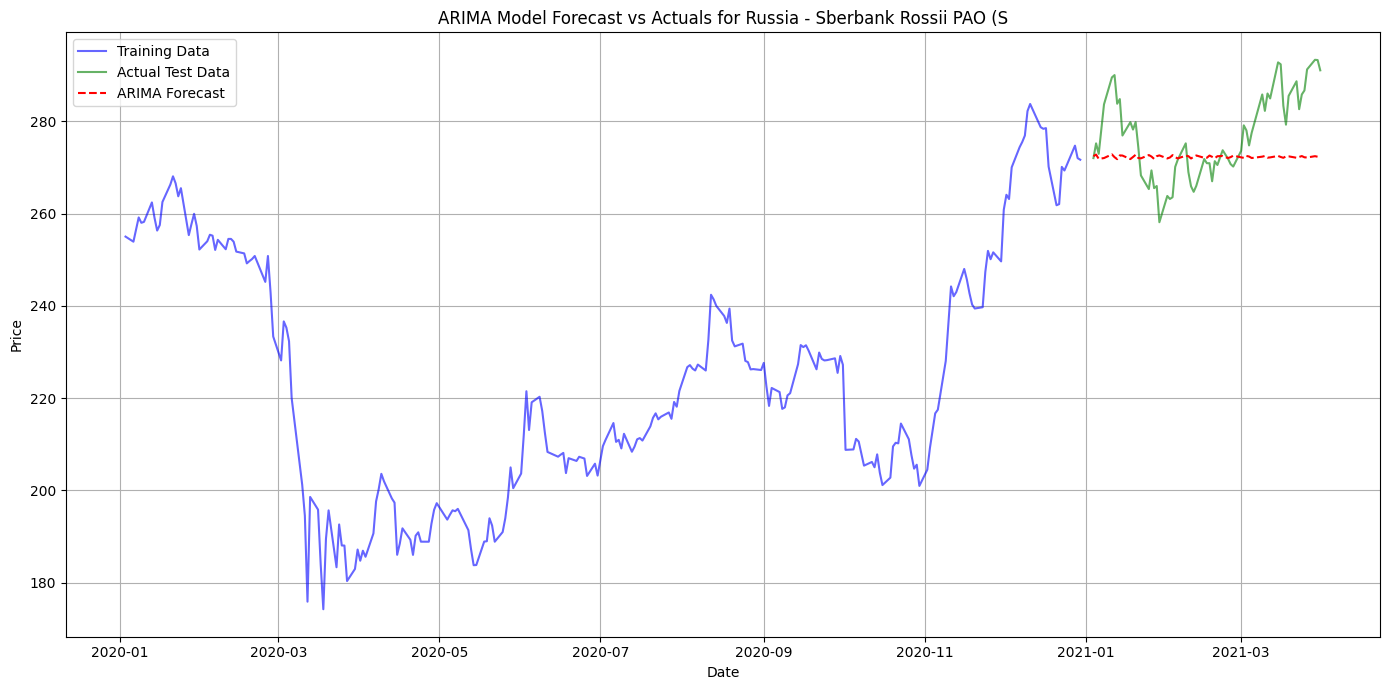

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Turkey - Koc Holding AS (KCHOL)
Root Mean Squared Error (RMSE): 1.3917705977729935


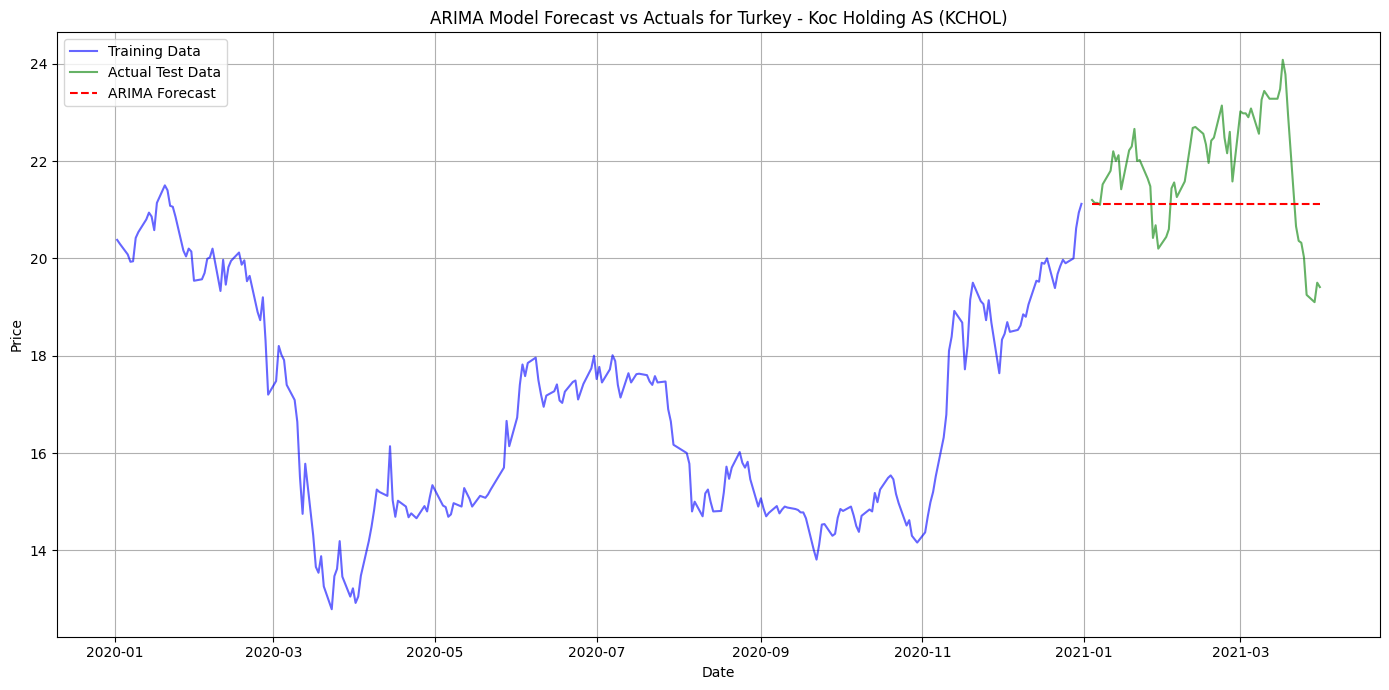

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Egypt - Medinet Nasr Housing (M
Root Mean Squared Error (RMSE): 0.1183408375255089


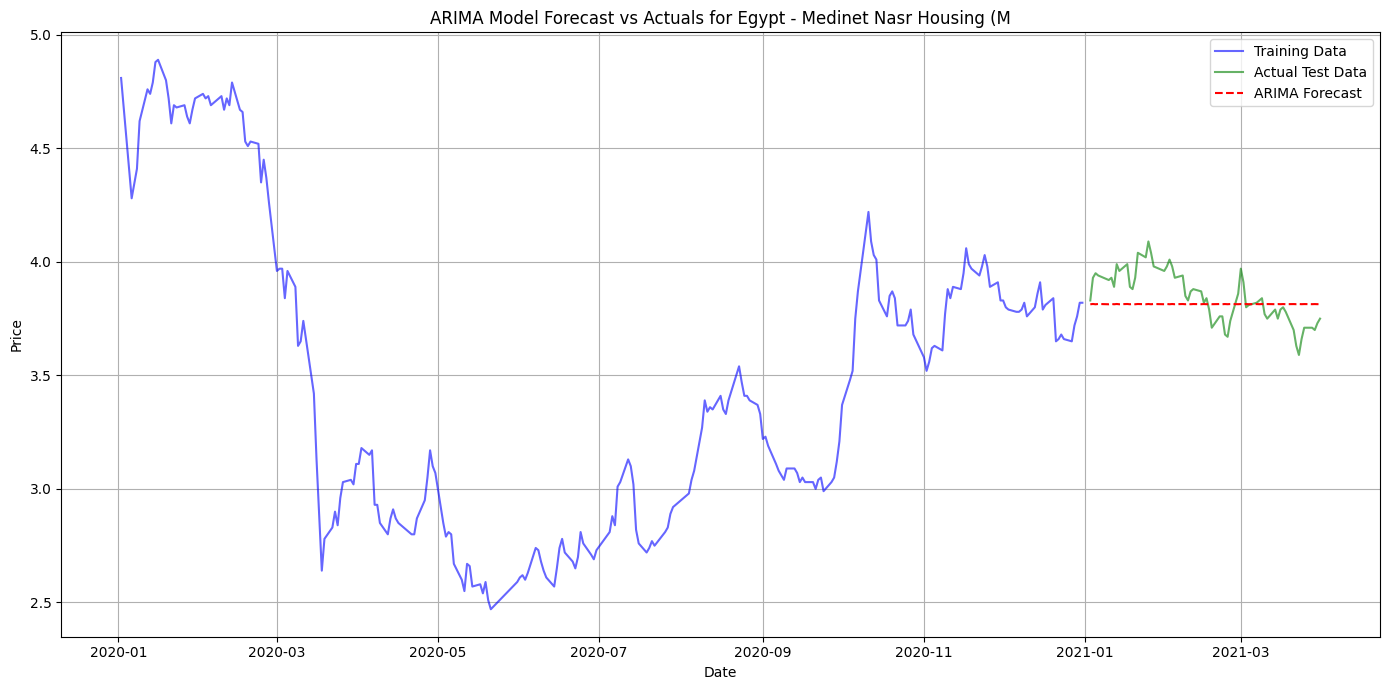

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Brazil - Minerva SABrazil (BEEF
Root Mean Squared Error (RMSE): 0.6024056825341534


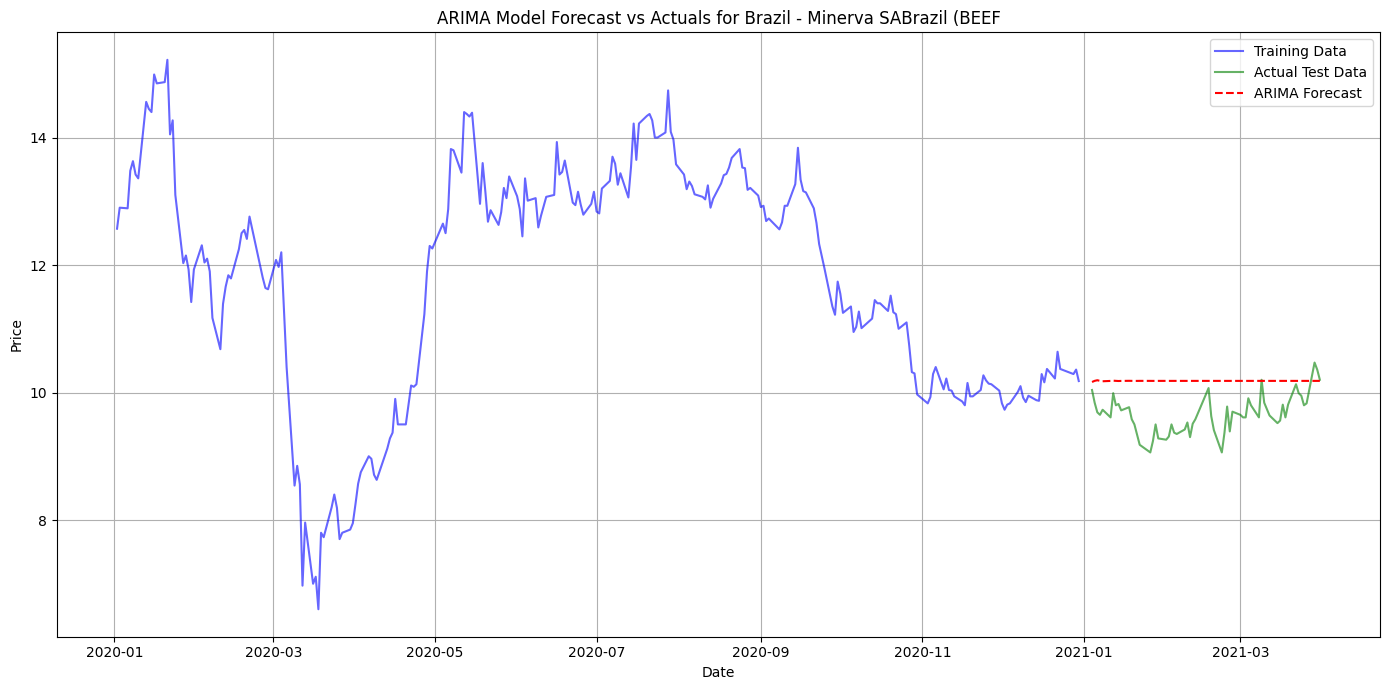

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Argentina - Pampa Energia SA (P
Root Mean Squared Error (RMSE): 6.219677824981016


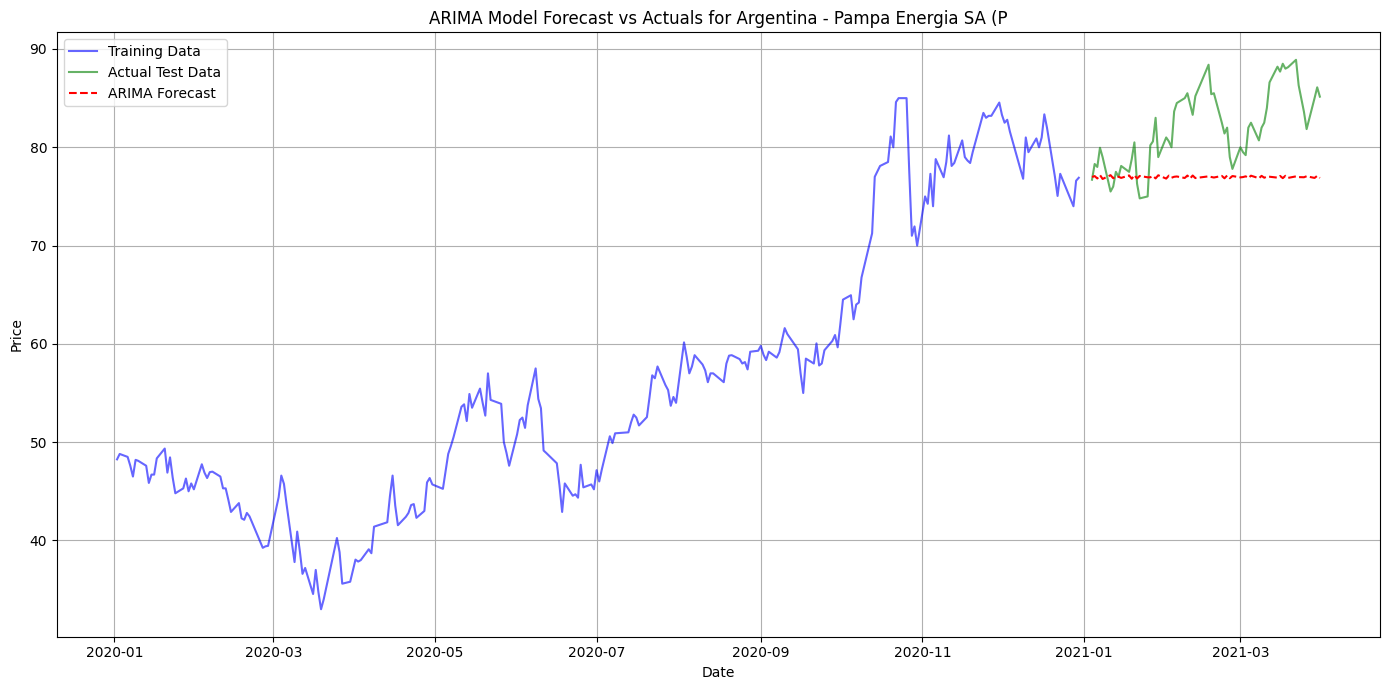

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Colombia - Cementos Argos SA (C
Root Mean Squared Error (RMSE): 1606.227604138943


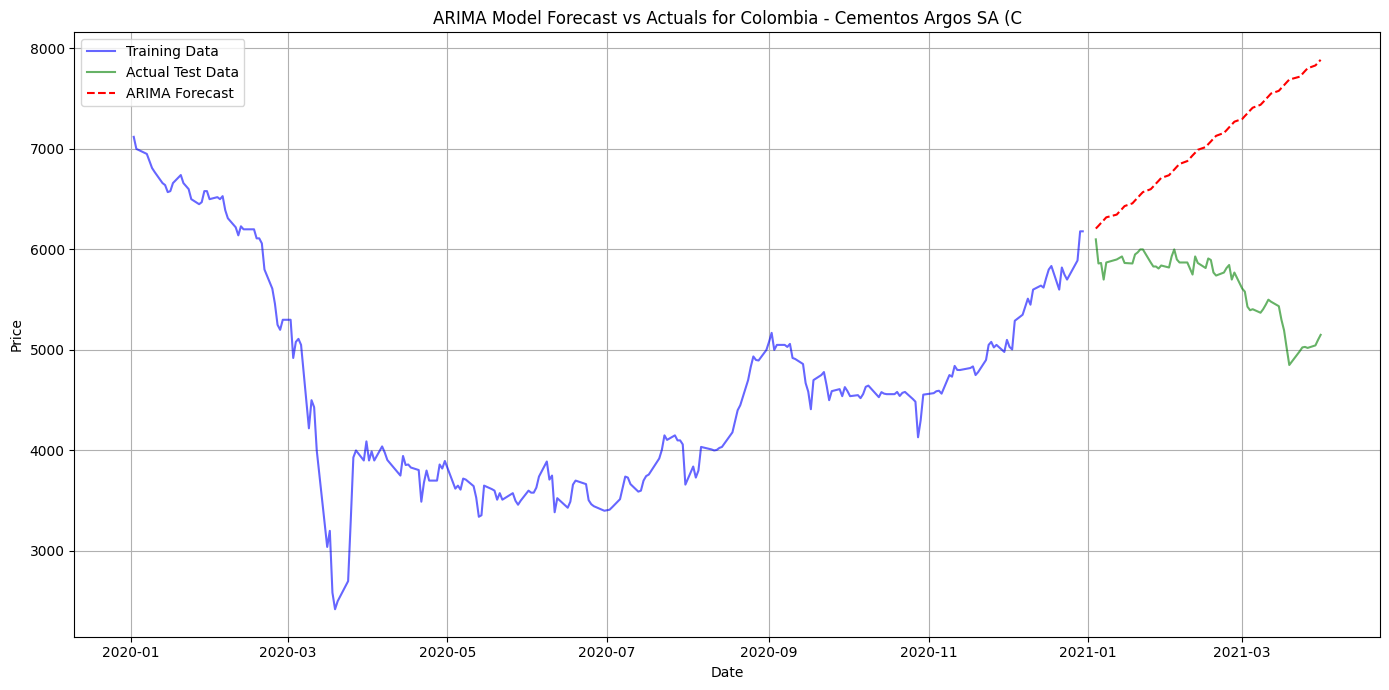

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: South Africa - Impala Platinum 
Root Mean Squared Error (RMSE): 4547.668585936516


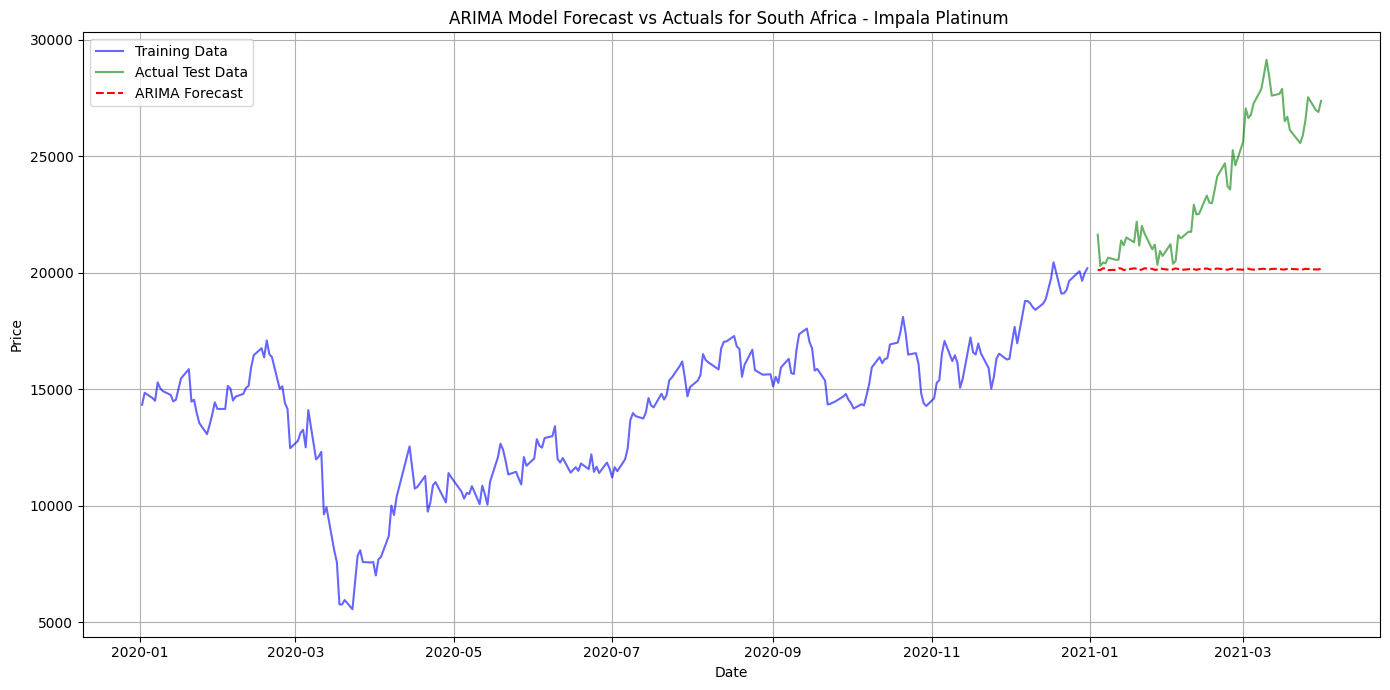

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: South Korea - Dongkuk Steel Mil
Root Mean Squared Error (RMSE): 1587.469158465997


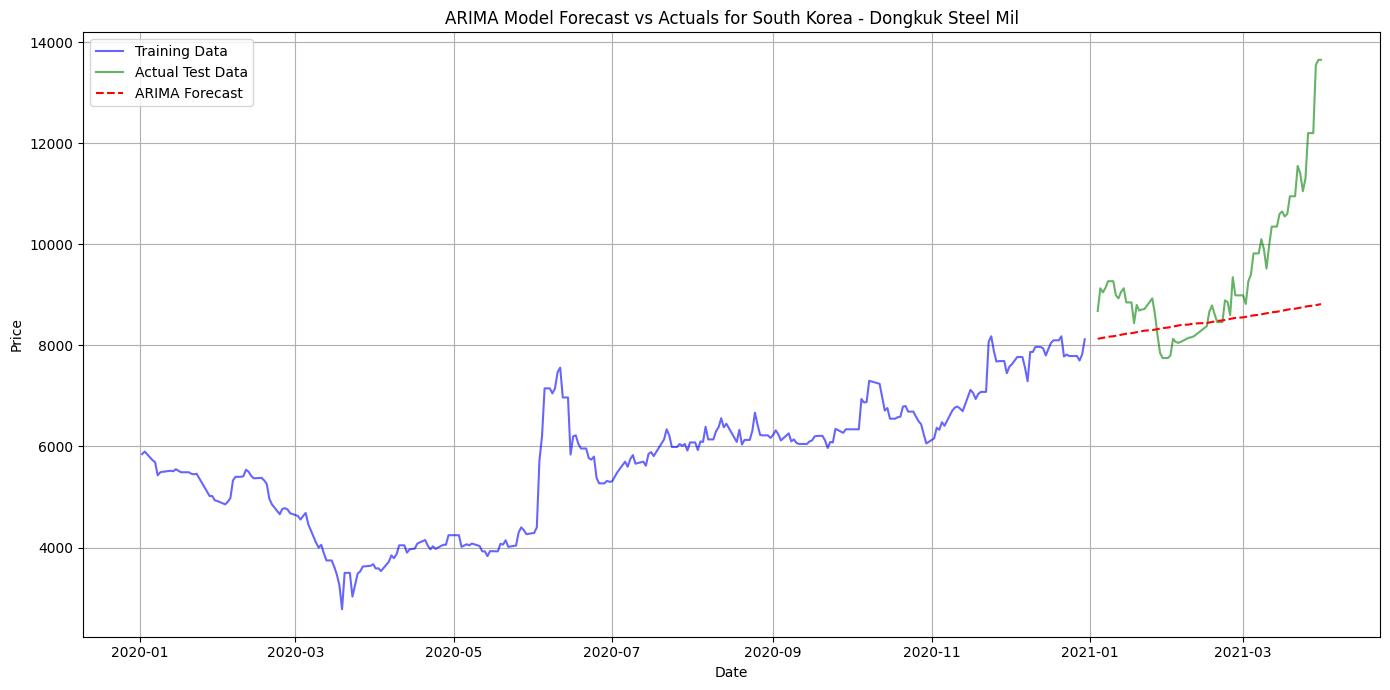

In [17]:
# Loop through each row in results_df
for index, row in results_df.iterrows():
    company_name = row['Company']
    best_order = row['Best_Order']
    
    # Use the train_test_arima_for_company function for each company
    train_test_arima_for_company(company_name, train, test, *best_order)

## Model Evaluation

- Predict on the testing set.
- Calculate metrics like MAE, RMSE, and capital returns.

# Investment Recommendations